In [ ]:
!gdown 1ZhLLXzsfwCTakiULGlDdkJEfGK6TNVro
!unzip -q Masinsko.zip -d ./Masinsko

Downloading...
From (original): https://drive.google.com/uc?id=1ZhLLXzsfwCTakiULGlDdkJEfGK6TNVro
From (redirected): https://drive.google.com/uc?id=1ZhLLXzsfwCTakiULGlDdkJEfGK6TNVro&confirm=t&uuid=f6b27689-4fd8-4656-9f77-475acbaf2f0f
To: /content/Masinsko.zip
100% 68.4M/68.4M [00:01<00:00, 34.3MB/s]


In [ ]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from PIL import Image
import random

from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes, box_iou, nms
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from sklearn.model_selection import train_test_split
from tqdm import tqdm

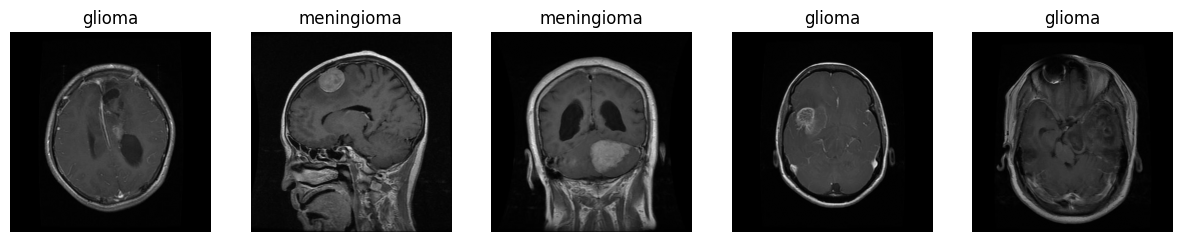

In [ ]:
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

img_root = Path("Masinsko/Pravi")
mask_root = Path("Masinsko/Maske")

class_names = {1: "meningioma", 2: "glioma", 3: "pituitary"}

image_paths = []
labels = []

for class_dir in sorted(img_root.iterdir()):
    if class_dir.is_dir():
        label = int(class_dir.name)
        for img_path in sorted(class_dir.glob("*.jpg")):
            image_paths.append(img_path)
            labels.append(label)

sample_indices = random.sample(range(len(image_paths)), 5)

plt.figure(figsize=(15,5))
for i, idx in enumerate(sample_indices):
    img = Image.open(image_paths[idx])
    plt.subplot(1,5,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(class_names[labels[idx]])
    plt.axis('off')
plt.show()

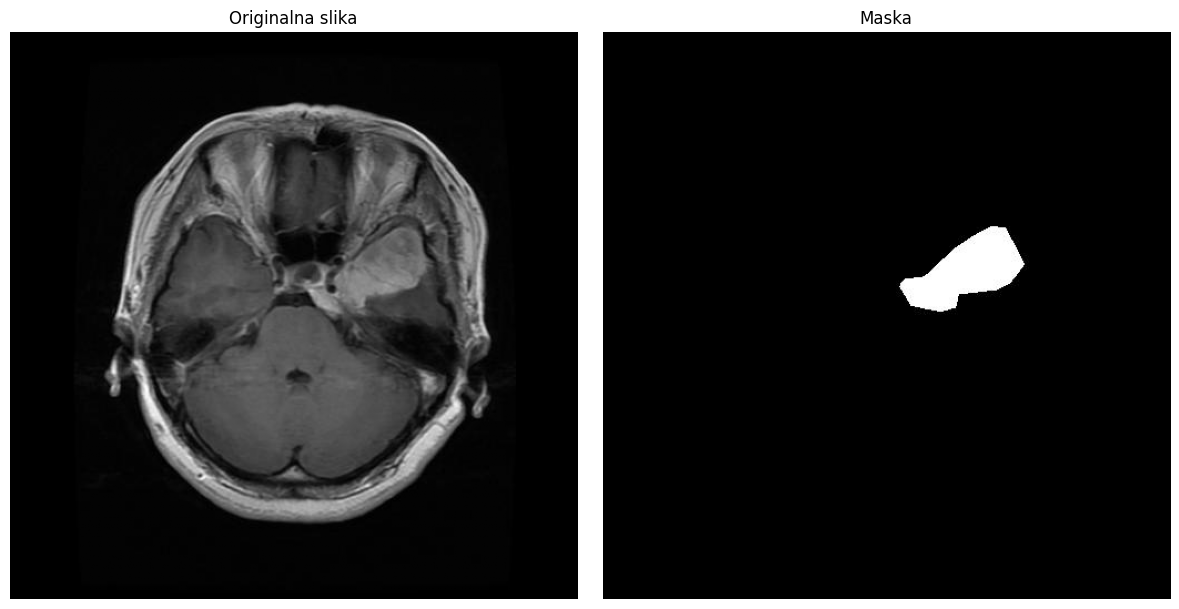

In [ ]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

image = read_image(image_path).float() / 255.0
mask = read_image(mask_path).float() / 255.0

if image.shape[0] > 1:
    image = image[0:1]
if mask.shape[0] > 1:
    mask = mask[0:1]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Originalna slika")
plt.imshow(image.squeeze(), cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Maska")
plt.imshow(mask.squeeze(), cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:

IMG_ROOT = Path("Masinsko/Pravi")
MASK_ROOT = Path("Masinsko/Maske")


NUM_CLASSES = 4
BATCH_SIZE = 8
NUM_EPOCHS = 20
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 5e-5


IMAGE_SIZE = (128, 128)


DETECTION_THRESHOLD = 0.4
IOU_THRESHOLD = 0.3


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)


CLASS_NAMES = {1: "meningioma", 2: "glioma", 3: "pituitary"}
CLASS_COLORS = {1: '#00FF00', 2: '#0000FF', 3: '#FFA500'}

cuda


In [ ]:
from torchvision.transforms import functional as F
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from PIL import Image
import torch
import random

class BrainTumorDataset(Dataset):
    def __init__(self, img_paths, mask_paths, labels, transform=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")
        label = self.labels[idx]

        mask = torch.as_tensor(np.array(mask), dtype=torch.uint8)
        binary_mask = (mask > 0).to(torch.uint8)

        if binary_mask.sum() > 0:
            masks = binary_mask.unsqueeze(0)
        else:
            masks = torch.zeros((0, mask.shape[0], mask.shape[1]), dtype=torch.uint8)

        boxes = masks_to_boxes(masks)
        valid = (boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1])
        boxes = boxes[valid]
        masks = masks[valid]

        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            masks = torch.zeros((0, mask.shape[0], mask.shape[1]), dtype=torch.uint8)
            labels_tensor = torch.zeros((0,), dtype=torch.int64)
            area = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)
        else:
            labels_tensor = torch.ones((boxes.shape[0],), dtype=torch.int64) * label
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {
            "boxes": tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=(mask.shape[0], mask.shape[1])),
            "masks": tv_tensors.Mask(masks),
            "labels": labels_tensor,
            "image_id": idx,
            "area": area,
            "iscrowd": iscrowd
        }

        if self.transform is not None:
            img, target = self.transform(img, target)

        return img, target



In [ ]:
def to_tensor_mri(img):

    if not isinstance(img, torch.Tensor):
        from torchvision.transforms.functional import to_tensor
        img = to_tensor(img)

    img = img.float()
    if img.max() > 1.0:
        img = img / 255.0

    if img.shape[0] == 1:
        img = img.repeat(3, 1, 1)

    return img


In [ ]:
def train_transform(img, target):

    orig_w, orig_h = img.size

    if random.random() > 0.3:
        angle = random.uniform(-20, 20)
        img = F.rotate(img, angle)
        target["masks"] = F.rotate(target["masks"], angle)

    # DODAJ horizontalno okretanje
    if random.random() > 0.5:
        img = F.hflip(img)
        target["masks"] = F.hflip(target["masks"])
        # Podesite boxes nakon flip-a
        boxes = target["boxes"]
        width = img.size[0]
        boxes[:, [0, 2]] = width - boxes[:, [2, 0]]
        target["boxes"] = boxes

    # Više augmentacije
    if random.random() > 0.3:
        img = F.adjust_brightness(img, random.uniform(0.7, 1.3))
    if random.random() > 0.3:
        img = F.adjust_contrast(img, random.uniform(0.7, 1.3))

    # DODAJ Gaussian noise
    if random.random() > 0.5:
        noise = torch.randn_like(F.to_tensor(img)) * 0.05
        img_tensor = F.to_tensor(img) + noise
        img = F.to_pil_image(img_tensor.clamp(0, 1))

    img = F.resize(img, IMAGE_SIZE, antialias=True)
    target["masks"] = F.resize(target["masks"], IMAGE_SIZE)


    scale_w = IMAGE_SIZE[0] / orig_w
    scale_h = IMAGE_SIZE[1] / orig_h
    boxes = target["boxes"]
    boxes[:, [0, 2]] *= scale_w
    boxes[:, [1, 3]] *= scale_h
    target["boxes"] = boxes


    img = F.to_tensor(img)
    img = F.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    return img, target


In [ ]:

def val_transform(img, target):

    orig_w, orig_h = img.size

    img = F.resize(img, IMAGE_SIZE, antialias=True)
    target["masks"] = F.resize(target["masks"], IMAGE_SIZE)

    scale_w = IMAGE_SIZE[0] / orig_w
    scale_h = IMAGE_SIZE[1] / orig_h
    boxes = target["boxes"]
    boxes[:, [0, 2]] *= scale_w
    boxes[:, [1, 3]] *= scale_h
    target["boxes"] = boxes

    img = F.to_tensor(img)
    img = F.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    return img, target


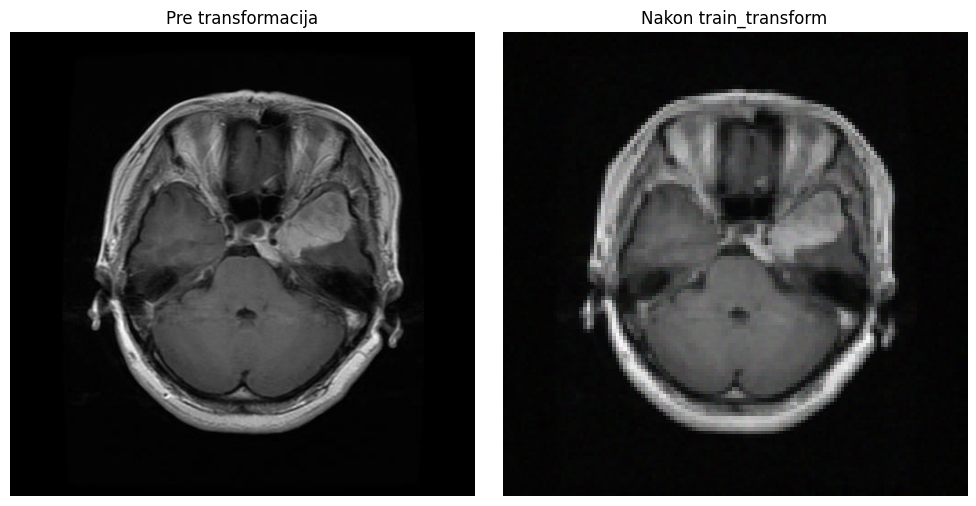

In [ ]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
from torchvision.ops import masks_to_boxes


img_path = Path("Masinsko/Pravi/1/1.jpg")
mask_path = Path("Masinsko/Maske/1/1.jpg")


image = Image.open(img_path).convert("RGB")
mask = Image.open(mask_path).convert("L")

mask_tensor = torch.as_tensor(np.array(mask), dtype=torch.uint8)
binary_mask = (mask_tensor > 0).to(torch.uint8)
masks = binary_mask.unsqueeze(0)
boxes = masks_to_boxes(masks)
target = {
    "boxes": boxes,
    "masks": masks,
    "labels": torch.tensor([1]),
    "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
    "iscrowd": torch.zeros((boxes.shape[0],), dtype=torch.int64)
}


img_before = F.to_tensor(image)
img_after, target_after = train_transform(image, target.copy())


fig, axes = plt.subplots(1, 2, figsize=(10, 5))


axes[0].imshow(img_before.permute(1, 2, 0))
axes[0].set_title("Pre transformacija")
axes[0].axis("off")


img_show = img_after.clone()
img_show = img_show * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
img_show = img_show + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
img_show = img_show.clamp(0, 1)

axes[1].imshow(img_show.permute(1, 2, 0))
axes[1].set_title("Nakon train_transform")
axes[1].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))


def move_to_device(images, targets, device):
    imgs = [img.to(device) for img in images]
    targs = []
    for t in targets:
        new_t = {}
        for k, v in t.items():
            if isinstance(v, torch.Tensor):
                new_t[k] = v.to(device)
            else:
                new_t[k] = v
        targs.append(new_t)
    return imgs, targs

In [ ]:

all_img_paths = []
all_mask_paths = []
all_labels = []

for cls_folder in sorted(os.listdir(IMG_ROOT)):
    img_folder = os.path.join(IMG_ROOT, cls_folder)
    mask_folder = os.path.join(MASK_ROOT, cls_folder)

    if not os.path.isdir(img_folder) or not os.path.isdir(mask_folder):
        continue

    label = int(cls_folder)
    for f in sorted(os.listdir(img_folder)):
        img_path = os.path.join(img_folder, f)
        mask_path = os.path.join(mask_folder, f)

        if os.path.isfile(img_path) and os.path.isfile(mask_path):
            all_img_paths.append(img_path)
            all_mask_paths.append(mask_path)
            all_labels.append(label)

In [ ]:

train_imgs, temp_imgs, train_masks, temp_masks, train_labels, temp_labels = train_test_split(
    all_img_paths, all_mask_paths, all_labels,
    test_size=0.2, stratify=all_labels, random_state=42
)

val_imgs, test_imgs, val_masks, test_masks, val_labels, test_labels = train_test_split(
    temp_imgs, temp_masks, temp_labels,
    test_size=0.5, stratify=temp_labels, random_state=42
)

print(f"Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")

Train: 2451, Val: 306, Test: 307


In [ ]:
train_dataset = BrainTumorDataset(train_imgs, train_masks, train_labels, transform=train_transform)
val_dataset = BrainTumorDataset(val_imgs, val_masks, val_labels, transform=val_transform)
test_dataset = BrainTumorDataset(test_imgs, test_masks, test_labels, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

   Train batches: 307
   Val batches: 39
   Test batches: 39


In [ ]:
weights = torchvision.models.detection.MaskRCNN_ResNet50_FPN_Weights.DEFAULT
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=weights)


in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_features, NUM_CLASSES
)


in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
    in_features_mask, hidden_layer, NUM_CLASSES
)


model.roi_heads.box_predictor.cls_score = torch.nn.Sequential(
    torch.nn.Dropout(0.3),
    model.roi_heads.box_predictor.cls_score
)

model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


100%|██████████| 170M/170M [00:00<00:00, 187MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 15.83 MiB/s, done.
Resolving deltas: 100% (2657/2657), done.
Updating files: 100% (248/248), done.


In [ ]:

summary(model=model,
        input_size=(32, 1, 128, 128),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
MaskRCNN (MaskRCNN)                                     [32, 1, 128, 128]    [100, 4]             --                   Partial
├─GeneralizedRCNNTransform (transform)                  [32, 1, 128, 128]    [32, 3, 800, 800]    --                   --
├─BackboneWithFPN (backbone)                            [32, 3, 800, 800]    [32, 256, 13, 13]    --                   Partial
│    └─IntermediateLayerGetter (body)                   [32, 3, 800, 800]    [32, 2048, 25, 25]   --                   Partial
│    │    └─Conv2d (conv1)                              [32, 3, 800, 800]    [32, 64, 400, 400]   (9,408)              False
│    │    └─FrozenBatchNorm2d (bn1)                     [32, 64, 400, 400]   [32, 64, 400, 400]   --                   --
│    │    └─ReLU (relu)                                 [32, 64, 400, 400]   [32, 64, 400, 400]   --                   --

In [ ]:
params_to_optimize = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params_to_optimize, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

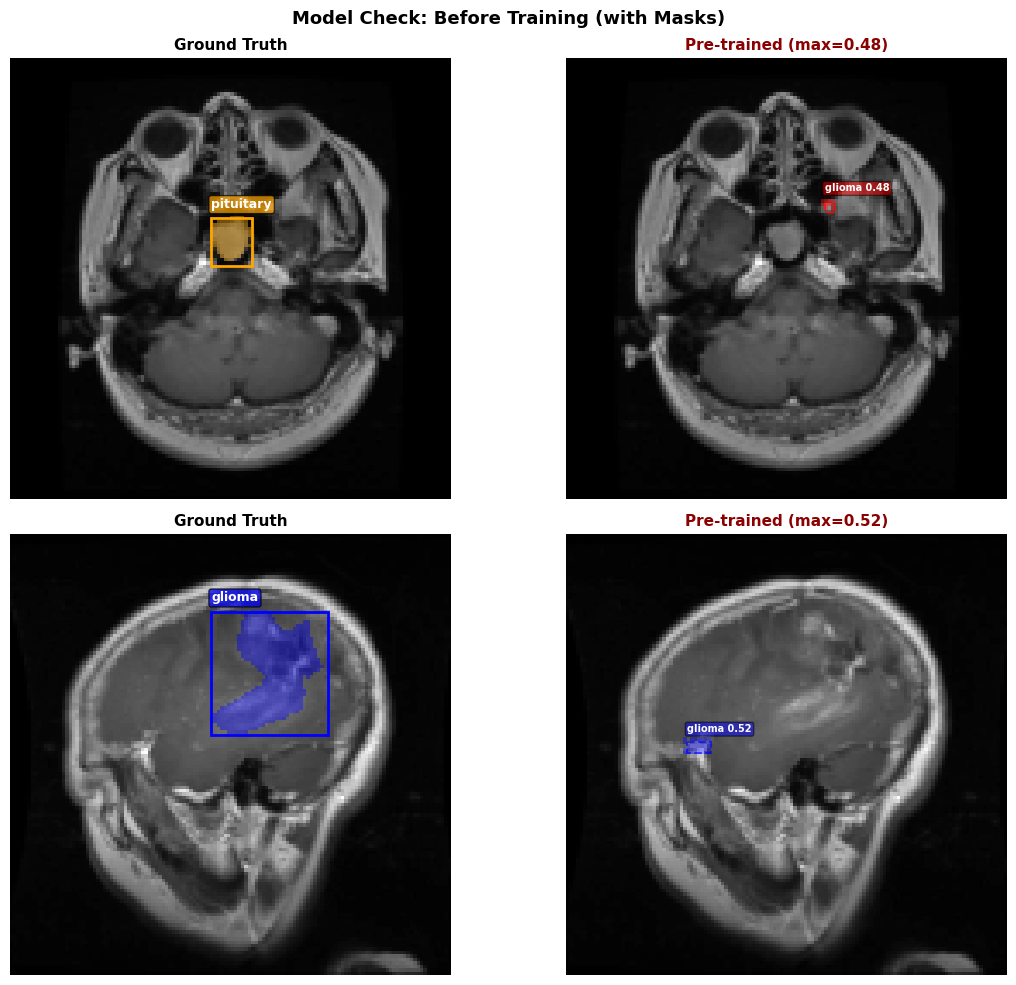

In [ ]:
model.eval()

random_batch_idx = random.randint(0, len(val_loader) - 1)
for batch_idx, (images, targets) in enumerate(val_loader):
    if batch_idx == random_batch_idx:
        break

images, targets = move_to_device(images, targets, DEVICE)
with torch.no_grad():
    predictions = model(images)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

from matplotlib.colors import to_rgb

for i in range(min(2, len(images))):

    img = images[i].cpu().permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)[:, :, 0]

    gt_boxes = targets[i]['boxes'].cpu().numpy()
    gt_labels = targets[i]['labels'].cpu().numpy()
    gt_masks = targets[i]['masks'].cpu().numpy()


    pred_boxes = predictions[i]['boxes'].cpu().numpy()
    pred_scores = predictions[i]['scores'].cpu().numpy()
    pred_labels = predictions[i]['labels'].cpu().numpy()
    pred_masks = predictions[i]['masks'].cpu().numpy()


    axes[i*2].imshow(img, cmap='gray')


    if len(gt_masks) > 0:
        for mask, label in zip(gt_masks, gt_labels):
            color = CLASS_COLORS.get(label, 'white')


            if color.startswith('#'):
                rgb_color = tuple(int(color.lstrip('#')[j:j+2], 16)/255.0 for j in (0, 2, 4))
            else:
                rgb_color = to_rgb(color)


            colored_mask = np.zeros((*mask.shape, 4))
            colored_mask[mask > 0.5] = (*rgb_color, 0.4)
            axes[i*2].imshow(colored_mask)

    if len(gt_boxes) > 0:
        for box, label in zip(gt_boxes, gt_labels):
            color = CLASS_COLORS.get(label, 'white')
            if color.startswith('#'):
                edge_rgb = color
            else:
                edge_rgb = 'white'

            rect = patches.Rectangle(
                (box[0], box[1]), box[2]-box[0], box[3]-box[1],
                linewidth=2, edgecolor=edge_rgb, facecolor='none'
            )
            axes[i*2].add_patch(rect)
            axes[i*2].text(
                box[0], box[1]-3,
                CLASS_NAMES.get(label, "Unknown"),
                color='white', fontsize=9, weight='bold',
                bbox=dict(boxstyle="round,pad=0.2", fc=edge_rgb, alpha=0.7)
            )

    axes[i*2].set_title('Ground Truth', fontsize=11, weight='bold')
    axes[i*2].axis('off')


    axes[i*2+1].imshow(img, cmap='gray')

    if len(pred_scores) > 0:
        best_idx = 0
        box = pred_boxes[best_idx]
        score = pred_scores[best_idx]
        label = pred_labels[best_idx]
        mask = pred_masks[best_idx, 0]

        color = CLASS_COLORS.get(label, 'red') if score >= 0.5 else 'red'


        if mask.shape != img.shape:
            from scipy.ndimage import zoom
            zoom_factors = (img.shape[0] / mask.shape[0], img.shape[1] / mask.shape[1])
            mask = zoom(mask, zoom_factors, order=1)

        if color.startswith('#'):
            rgb_color = tuple(int(color.lstrip('#')[j:j+2], 16)/255.0 for j in (0, 2, 4))
        else:
            rgb_color = to_rgb(color)


        colored_mask = np.zeros((*mask.shape, 4))
        colored_mask[mask > 0.5] = (*rgb_color, 0.4)
        axes[i*2+1].imshow(colored_mask)

        rect = patches.Rectangle(
            (box[0], box[1]), box[2]-box[0], box[3]-box[1],
            linewidth=1.5, edgecolor=color, facecolor='none',
            linestyle='--', alpha=0.6
        )
        axes[i*2+1].add_patch(rect)
        axes[i*2+1].text(
            box[0], box[1]-3,
            f'{CLASS_NAMES.get(label, f"C{label}")} {score:.2f}',
            color='white', fontsize=7, weight='bold',
            bbox=dict(boxstyle="round,pad=0.2", fc=color, alpha=0.5)
        )
        axes[i*2+1].set_title(f'Pre-trained (max={pred_scores[0]:.2f})',
                             fontsize=11, weight='bold', color='darkred')
    else:
        axes[i*2+1].text(
            0.5, 0.5, 'No Detections',
            transform=axes[i*2+1].transAxes,
            ha='center', va='center',
            fontsize=11, weight='bold', color='red'
        )
        axes[i*2+1].set_title('Pre-trained', fontsize=11, weight='bold')

    axes[i*2+1].axis('off')

plt.suptitle('Model Check: Before Training (with Masks)', fontsize=13, weight='bold', y=0.98)
plt.tight_layout()
plt.show()


In [ ]:
def train_one_epoch(model, train_loader, optimizer, device):

    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=" Training", leave=False)

    for images, targets in progress_bar:
        images, targets = move_to_device(images, targets, device)

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        with torch.no_grad():
            model.eval()
            preds = model(images)
            model.train()

            for pred, targ in zip(preds, targets):
                if len(pred["boxes"]) > 0 and len(targ["boxes"]) > 0:
                    pred_label = pred["labels"][0].item()
                    true_label = targ["labels"][0].item()
                    if pred_label == true_label and pred["scores"][0] > 0.5:
                        correct += 1
                total += 1

        progress_bar.set_postfix({"Loss": f"{losses.item():.4f}"})

    avg_loss = total_loss / len(train_loader)
    acc = correct / total if total > 0 else 0

    return avg_loss, acc


In [ ]:
def evaluate(model, val_loader, device):

    model.eval()
    correct = 0
    total = 0

    progress_bar = tqdm(val_loader, desc=" Validation", leave=False)

    with torch.no_grad():
        for images, targets in progress_bar:
            images, targets = move_to_device(images, targets, device)

            preds = model(images)

            for pred, targ in zip(preds, targets):
                if len(pred["boxes"]) > 0 and len(targ["boxes"]) > 0:

                    best_idx = pred["scores"].argmax()
                    pred_label = pred["labels"][best_idx].item()
                    true_label = targ["labels"][0].item()

                    if pred_label == true_label and pred["scores"][best_idx] > 0.5:
                        correct += 1
                total += 1

            progress_bar.set_postfix({"Correct": f"{correct}/{total}"})

    acc = correct / total if total > 0 else 0

    model.train()
    total_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = move_to_device(images, targets, device)
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()

    avg_loss = total_loss / len(val_loader)
    model.eval()

    return avg_loss, acc

In [ ]:

PATIENCE =7
best_val_loss = float("inf")
epochs_no_improve = 0
early_stop = False

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(NUM_EPOCHS):
    print(f"\n Epoch [{epoch+1}/{NUM_EPOCHS}]")

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, DEVICE)
    val_loss, val_acc = evaluate(model, val_loader, DEVICE)

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")


    if val_loss < best_val_loss - 1e-5:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_brain_tumor_model.pth")
        print(" Best model saved!")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f" No improvement for {epochs_no_improve} epochs.")

    if epochs_no_improve >= PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs.")
        early_stop = True
        break

if not early_stop:
    print("\nTraining finished without early stopping.")

print(f"\nBest Validation Loss: {best_val_loss:.4f}")



 Epoch [1/20]


Train Loss: 0.5686 | Val Loss: 0.4606
Train Acc: 41.37% | Val Acc: 65.69%
 Best model saved!

 Epoch [2/20]


Train Loss: 0.4619 | Val Loss: 0.4233
Train Acc: 76.99% | Val Acc: 80.07%
 Best model saved!

 Epoch [3/20]


Train Loss: 0.4311 | Val Loss: 0.4167
Train Acc: 83.48% | Val Acc: 83.99%
 Best model saved!

 Epoch [4/20]


Train Loss: 0.4148 | Val Loss: 0.4089
Train Acc: 87.47% | Val Acc: 86.27%
 Best model saved!

 Epoch [5/20]


Train Loss: 0.4032 | Val Loss: 0.3942
Train Acc: 89.76% | Val Acc: 87.58%
 Best model saved!

 Epoch [6/20]


Train Loss: 0.3876 | Val Loss: 0.3928
Train Acc: 90.94% | Val Acc: 86.93%
 Best model saved!

 Epoch [7/20]


Train Loss: 0.3766 | Val Loss: 0.3905
Train Acc: 92.62% | Val Acc: 85.95%
 Best model saved!

 Epoch [8/20]


Train Loss: 0.3625 | Val Loss: 0.3859
Train Acc: 94.41% | Val Acc: 89.87%
 Best model saved!

 Epoch [9/20]


Train Loss: 0.3550 | Val Loss: 0.3793
Train Acc: 94.70% | Val Acc: 92.16%
 Best model saved!

 Epoch [10/20]


Train Loss: 0.3559 | Val Loss: 0.4006
Train Acc: 96.00% | Val Acc: 88.89%
 No improvement for 1 epochs.

 Epoch [11/20]


Train Loss: 0.3459 | Val Loss: 0.3989
Train Acc: 96.78% | Val Acc: 89.54%
 No improvement for 2 epochs.

 Epoch [12/20]


Train Loss: 0.3361 | Val Loss: 0.3835
Train Acc: 96.82% | Val Acc: 95.42%
 No improvement for 3 epochs.

 Epoch [13/20]


Train Loss: 0.3258 | Val Loss: 0.3978
Train Acc: 97.67% | Val Acc: 91.50%
 No improvement for 4 epochs.

 Epoch [14/20]


Train Loss: 0.3056 | Val Loss: 0.3944
Train Acc: 98.37% | Val Acc: 91.83%
 No improvement for 5 epochs.

 Epoch [15/20]


Train Loss: 0.2967 | Val Loss: 0.3908
Train Acc: 98.57% | Val Acc: 93.14%
 No improvement for 6 epochs.

 Epoch [16/20]


Train Loss: 0.2902 | Val Loss: 0.4031
Train Acc: 98.65% | Val Acc: 93.14%
 No improvement for 7 epochs.

Early stopping triggered after 16 epochs.

Best Validation Loss: 0.3793


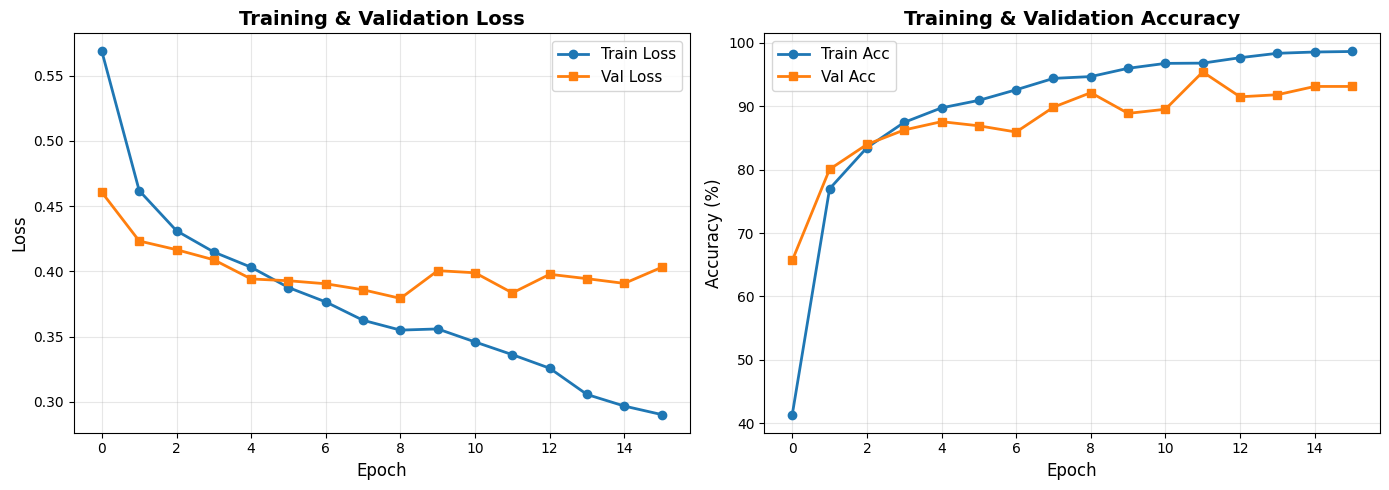

   Best Val Loss: 0.3793
   Final Train Acc: 98.65%
   Final Val Acc: 93.14%


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))


ax1.plot(train_losses, label='Train Loss', marker='o', linewidth=2)
ax1.plot(val_losses, label='Val Loss', marker='s', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)


ax2.plot([a*100 for a in train_accuracies], label='Train Acc', marker='o', linewidth=2)
ax2.plot([a*100 for a in val_accuracies], label='Val Acc', marker='s', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"   Best Val Loss: {min(val_losses):.4f}")
print(f"   Final Train Acc: {train_accuracies[-1]*100:.2f}%")
print(f"   Final Val Acc: {val_accuracies[-1]*100:.2f}%")

In [ ]:
def visualize_predictions(model, dataloader, device, num_samples=6):
    model.eval()

    random_batch_idx = random.randint(0, len(dataloader) - 1)
    for batch_idx, (images, targets) in enumerate(dataloader):
        if batch_idx == random_batch_idx:
            break

    images, targets = move_to_device(images, targets, device)

    with torch.no_grad():
        predictions = model(images)

    total_images = len(images)
    if total_images > num_samples:
        random_indices = random.sample(range(total_images), num_samples)
    else:
        random_indices = list(range(total_images))
        num_samples = total_images

    fig, axes = plt.subplots(num_samples, 2, figsize=(14, 6*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for plot_idx, img_idx in enumerate(random_indices):
        img = images[img_idx].cpu().permute(1, 2, 0).numpy()
        img_mean = np.array([0.485, 0.456, 0.406])
        img_std = np.array([0.229, 0.224, 0.225])
        img = img * img_std + img_mean
        img = np.clip(img, 0, 1)
        gray_img = img[:, :, 0]

        gt_boxes = targets[img_idx]['boxes'].cpu().numpy()
        gt_labels = targets[img_idx]['labels'].cpu().numpy()
        gt_masks = targets[img_idx]['masks'].cpu().numpy()
        true_class = CLASS_NAMES.get(targets[img_idx]["labels"][0].item(), "Unknown")

        pred_boxes = predictions[img_idx]['boxes'].cpu().numpy()
        pred_scores = predictions[img_idx]['scores'].cpu().numpy()
        pred_labels = predictions[img_idx]['labels'].cpu().numpy()
        pred_masks = predictions[img_idx]['masks'].cpu().numpy()

        print(f"\n Sample {plot_idx+1} (Image {img_idx} from batch {random_batch_idx}):")
        print(f"   Ground Truth: {true_class}")
        print(f"   Total predictions: {len(pred_scores)}")
        if len(pred_scores) > 0:
            print(f"   Max score: {pred_scores.max():.3f}")
            print(f"   Top prediction: {CLASS_NAMES.get(pred_labels[np.argmax(pred_scores)], 'Unknown')}")
            print(f"   Above threshold ({DETECTION_THRESHOLD}): {np.sum(pred_scores > DETECTION_THRESHOLD)}")

        axes[plot_idx, 0].imshow(gray_img, cmap='gray')
        if len(gt_masks) > 0:
            for mask, label in zip(gt_masks, gt_labels):
                color = CLASS_COLORS.get(label, 'white')
                rgb_color = tuple(int(color.lstrip('#')[i:i+2], 16)/255.0 for i in (0, 2, 4))
                colored_mask = np.zeros((*mask.shape, 4))
                colored_mask[mask > 0.5] = (*rgb_color, 0.4)  # 0.4 alpha for transparency
                axes[plot_idx, 0].imshow(colored_mask)

        for box, label in zip(gt_boxes, gt_labels):
            color = CLASS_COLORS.get(label, 'white')
            rect = patches.Rectangle(
                (box[0], box[1]), box[2]-box[0], box[3]-box[1],
                linewidth=2, edgecolor=color, facecolor='none'
            )
            axes[plot_idx, 0].add_patch(rect)
            class_name = CLASS_NAMES.get(label, "Unknown")
            axes[plot_idx, 0].text(
                box[0], box[1]-5, f'{class_name}',
                color='white', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.8)
            )

        axes[plot_idx, 0].set_title(f'GROUND TRUTH: {true_class}', fontsize=13, fontweight='bold')
        axes[plot_idx, 0].axis('off')
        axes[plot_idx, 1].imshow(gray_img, cmap='gray')

        if len(pred_scores) > 0:
            best_idx = np.argmax(pred_scores)

            box = pred_boxes[best_idx]
            score = pred_scores[best_idx]
            label = pred_labels[best_idx]
            mask = pred_masks[best_idx, 0]

            color = CLASS_COLORS.get(label, 'red')

            rgb_color = tuple(int(color.lstrip('#')[i:i+2], 16)/255.0 for i in (0, 2, 4))
            colored_mask = np.zeros((*mask.shape, 4))
            colored_mask[mask > 0.5] = (*rgb_color, 0.4)  # 0.4 alpha for transparency
            axes[plot_idx, 1].imshow(colored_mask)

            rect = patches.Rectangle(
                (box[0], box[1]), box[2]-box[0], box[3]-box[1],
                linewidth=2, edgecolor=color, facecolor='none', linestyle='--'
            )
            axes[plot_idx, 1].add_patch(rect)

            class_name = CLASS_NAMES.get(label, "Unknown")
            axes[plot_idx, 1].text(
                box[0], box[1]-5, f'{class_name} ({score:.2f})',
                color='white', fontsize=9, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.6)
            )
        else:
            axes[plot_idx, 1].text(
                0.5, 0.5, 'NO PREDICTIONS AT ALL',
                transform=axes[plot_idx, 1].transAxes,
                ha='center', va='center',
                fontsize=14, fontweight='bold', color='red'
            )

        axes[plot_idx, 1].set_title('PREDICTIONS', fontsize=13, fontweight='bold')
        axes[plot_idx, 1].axis('off')

    plt.tight_layout()
    plt.show()

    model.train()

 Visualizing predictions on validation set...

 Sample 1 (Image 1 from batch 13):
   Ground Truth: glioma
   Total predictions: 17
   Max score: 0.778
   Top prediction: glioma
   Above threshold (0.4): 1

 Sample 2 (Image 5 from batch 13):
   Ground Truth: glioma
   Total predictions: 4
   Max score: 0.966
   Top prediction: glioma
   Above threshold (0.4): 1

 Sample 3 (Image 7 from batch 13):
   Ground Truth: glioma
   Total predictions: 5
   Max score: 0.975
   Top prediction: glioma
   Above threshold (0.4): 1

 Sample 4 (Image 6 from batch 13):
   Ground Truth: glioma
   Total predictions: 1
   Max score: 0.990
   Top prediction: glioma
   Above threshold (0.4): 1

 Sample 5 (Image 4 from batch 13):
   Ground Truth: glioma
   Total predictions: 2
   Max score: 0.130
   Top prediction: glioma
   Above threshold (0.4): 0

 Sample 6 (Image 0 from batch 13):
   Ground Truth: glioma
   Total predictions: 7
   Max score: 0.922
   Top prediction: glioma
   Above threshold (0.4): 1


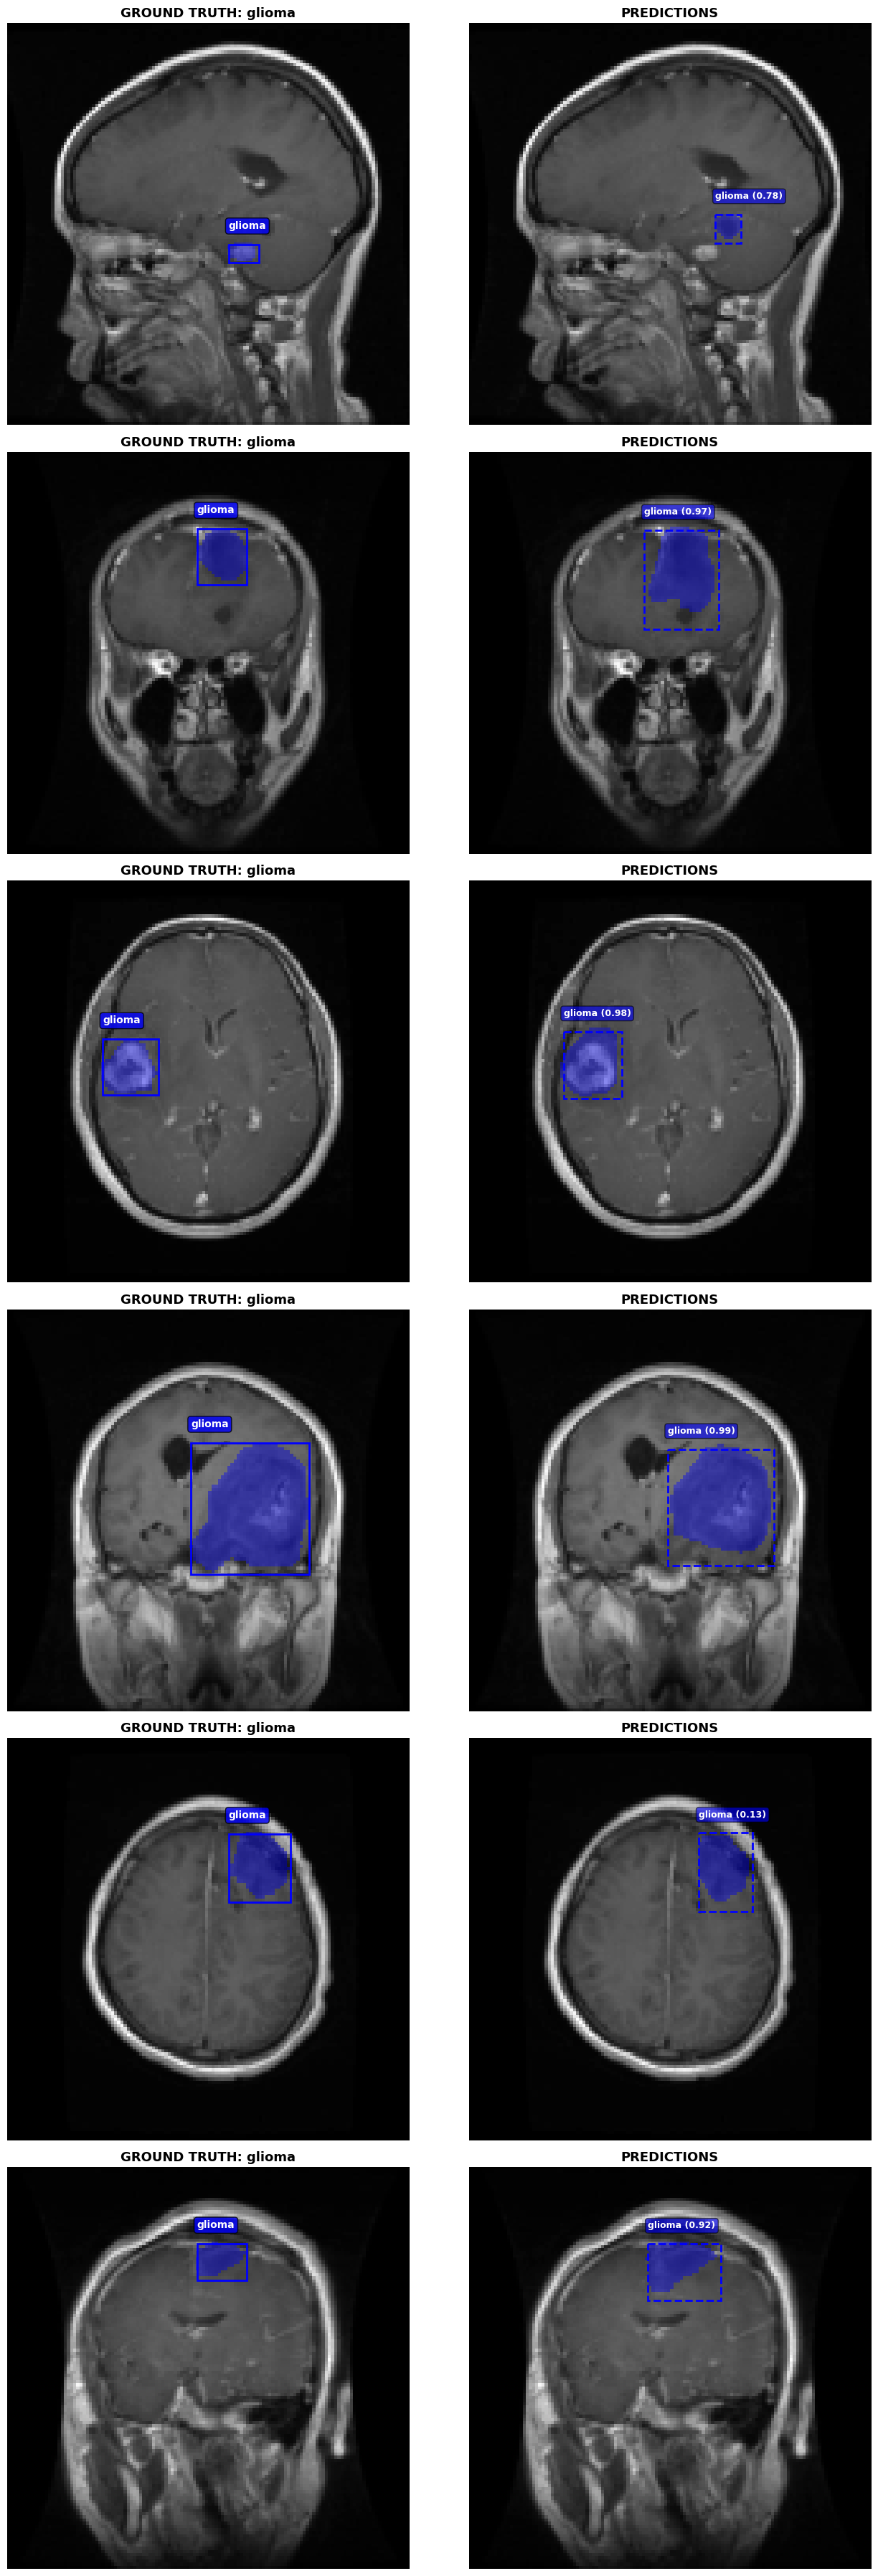


 Visualizing predictions on test set...

 Sample 1 (Image 5 from batch 8):
   Ground Truth: meningioma
   Total predictions: 3
   Max score: 0.971
   Top prediction: meningioma
   Above threshold (0.4): 2

 Sample 2 (Image 6 from batch 8):
   Ground Truth: pituitary
   Total predictions: 2
   Max score: 0.997
   Top prediction: pituitary
   Above threshold (0.4): 1

 Sample 3 (Image 0 from batch 8):
   Ground Truth: pituitary
   Total predictions: 5
   Max score: 0.970
   Top prediction: pituitary
   Above threshold (0.4): 1

 Sample 4 (Image 2 from batch 8):
   Ground Truth: meningioma
   Total predictions: 3
   Max score: 0.972
   Top prediction: meningioma
   Above threshold (0.4): 3

 Sample 5 (Image 7 from batch 8):
   Ground Truth: pituitary
   Total predictions: 2
   Max score: 0.987
   Top prediction: pituitary
   Above threshold (0.4): 1

 Sample 6 (Image 1 from batch 8):
   Ground Truth: meningioma
   Total predictions: 4
   Max score: 0.975
   Top prediction: meningioma
   

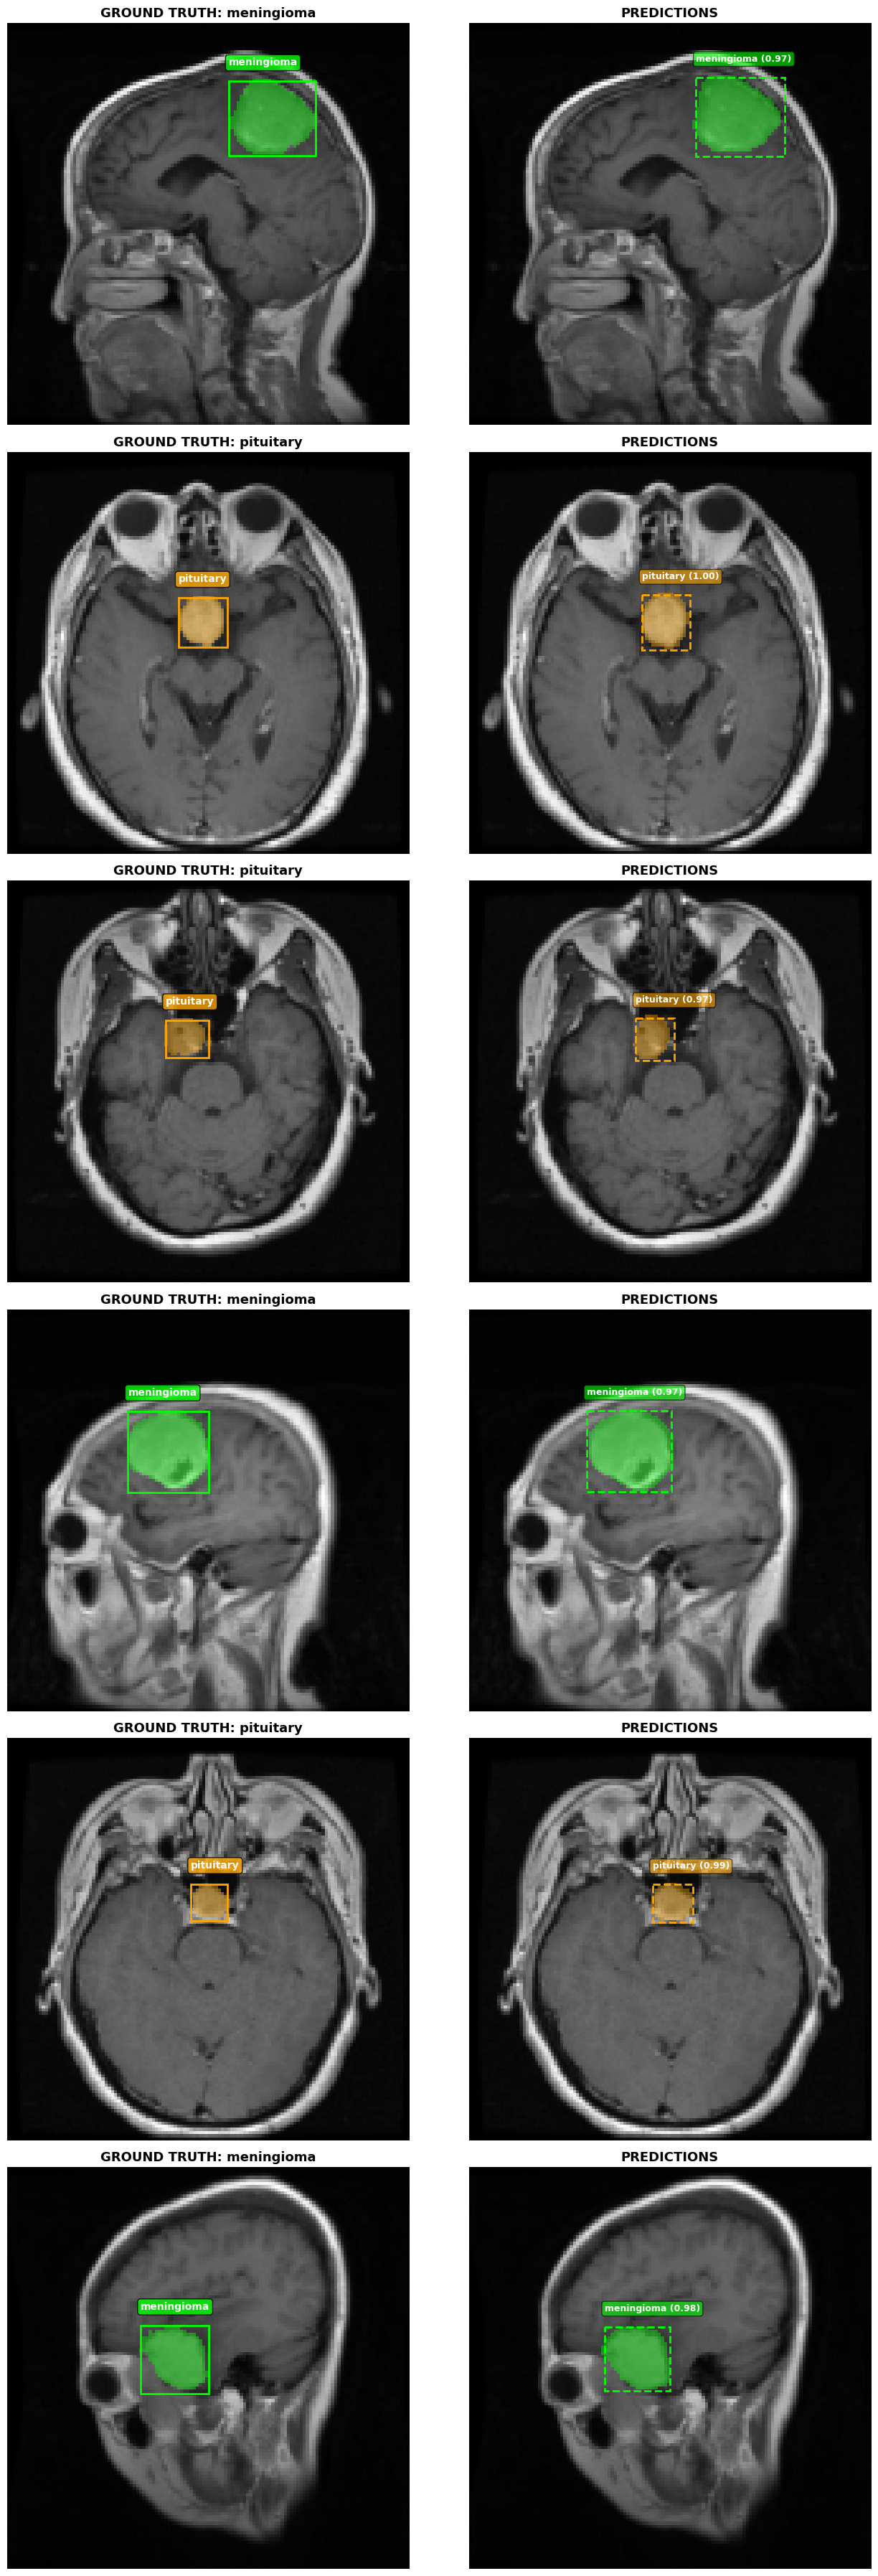

In [ ]:
print(" Visualizing predictions on validation set...")
visualize_predictions(model, val_loader, DEVICE, num_samples=6)

print("\n Visualizing predictions on test set...")
visualize_predictions(model, test_loader, DEVICE, num_samples=6)

In [ ]:
def quick_accuracy_check(model, dataloader, device, num_batches=5):
    model.eval()
    total_samples = 0
    correct_detections = 0

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(dataloader):
            if batch_idx >= num_batches:
                break

            images, targets = move_to_device(images, targets, device)
            predictions = model(images)

            for target, prediction in zip(targets, predictions):
                total_samples += 1
                if len(prediction['labels']) > 0 and len(target['labels']) > 0:
                    pred_label = prediction['labels'][0].item()
                    true_label = target['labels'][0].item()
                    if pred_label == true_label and prediction['scores'][0] > 0.5:
                        correct_detections += 1

    accuracy = correct_detections / total_samples if total_samples > 0 else 0
    print(f"\n Quick Accuracy Check:")
    print(f"   Correct: {correct_detections}/{total_samples}")
    print(f"   Accuracy: {accuracy*100:.2f}%")

    model.train()
    return accuracy

In [ ]:

print(" Running quick check on validation set...")
val_accuracy = quick_accuracy_check(model, val_loader, DEVICE, num_batches=5)

print("\n Running quick check on test set...")
test_accuracy = quick_accuracy_check(model, test_loader, DEVICE, num_batches=5)

 Running quick check on validation set...

 Quick Accuracy Check:
   Correct: 37/40
   Accuracy: 92.50%

 Running quick check on test set...

 Quick Accuracy Check:
   Correct: 38/40
   Accuracy: 95.00%




VALIDATION SET - CONFUSION MATRIX


Računanje predictions za confusion matrix...


Processing: 100%|██████████| 39/39 [00:30<00:00,  1.27it/s]


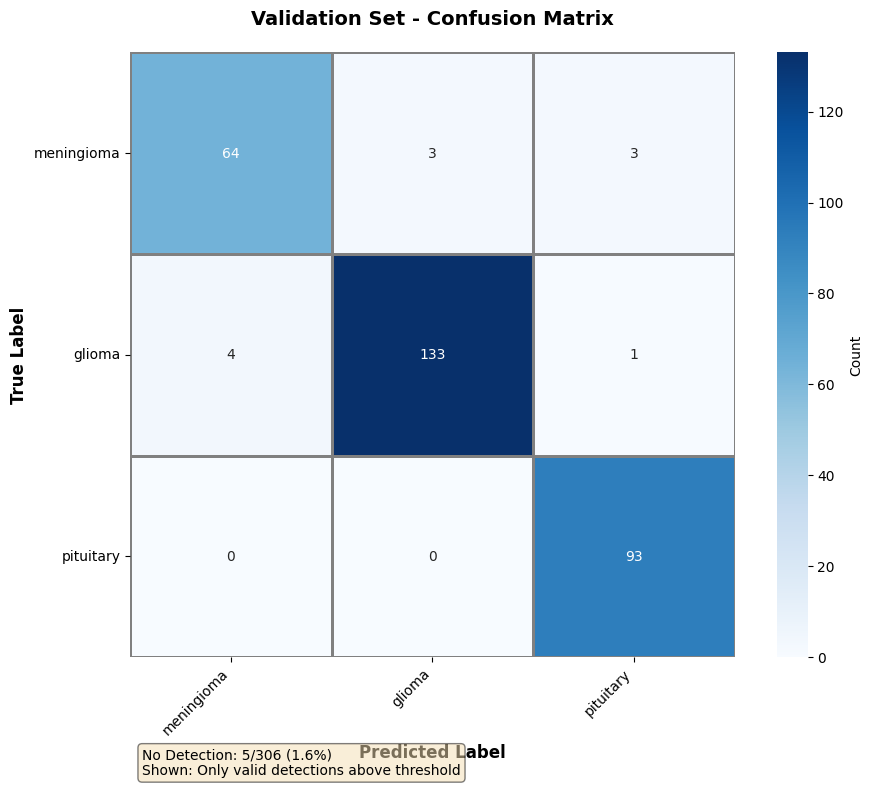

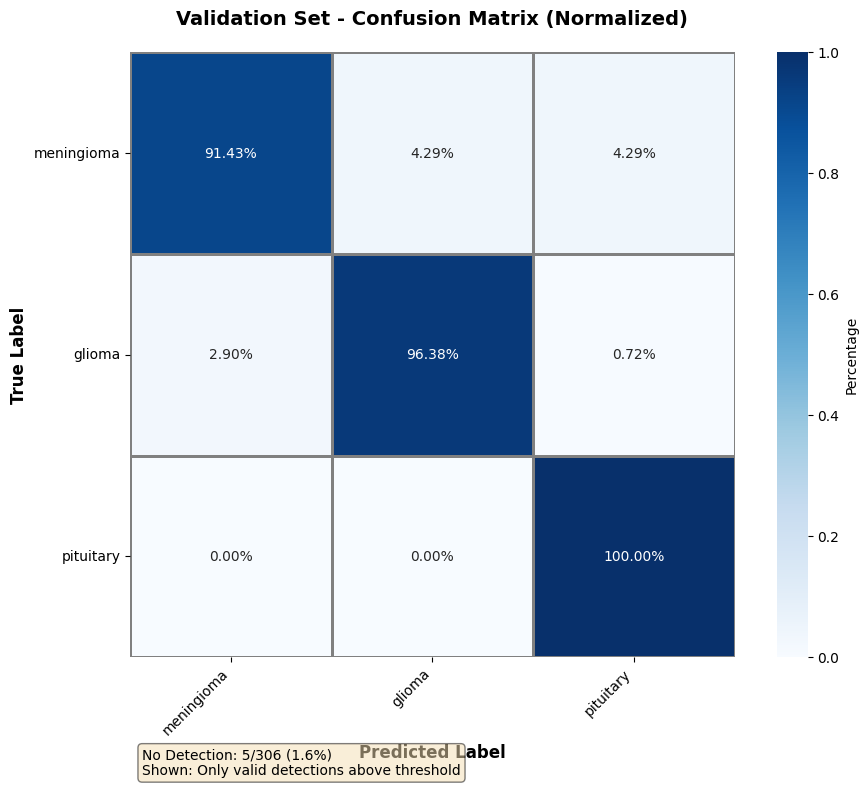


CLASSIFICATION REPORT (samo validne detekcije)
              precision    recall  f1-score   support

  meningioma       0.94      0.91      0.93        70
      glioma       0.98      0.96      0.97       138
   pituitary       0.96      1.00      0.98        93

    accuracy                           0.96       301
   macro avg       0.96      0.96      0.96       301
weighted avg       0.96      0.96      0.96       301


DETECTION STATISTICS
Ukupno uzoraka: 306
Validne detekcije (above threshold): 301 (98.4%)
No detection (below threshold): 5 (1.6%)

PER-CLASS ANALYSIS

MENINGIOMA (Class 1):
  Ground truth samples: 70
  Predicted as this class: 68
  Correctly classified: 64
  Class accuracy: 91.43%

GLIOMA (Class 2):
  Ground truth samples: 138
  Predicted as this class: 136
  Correctly classified: 133
  Class accuracy: 96.38%

PITUITARY (Class 3):
  Ground truth samples: 93
  Predicted as this class: 97
  Correctly classified: 93
  Class accuracy: 100.00%



TEST SET - CONFUSION 

Processing: 100%|██████████| 39/39 [00:30<00:00,  1.26it/s]


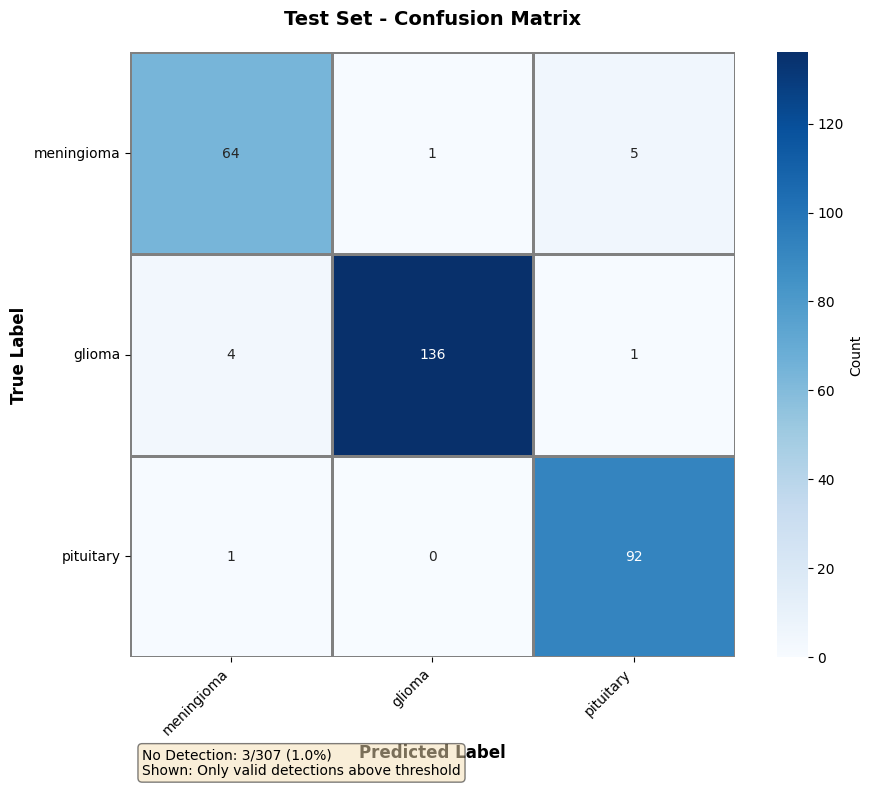

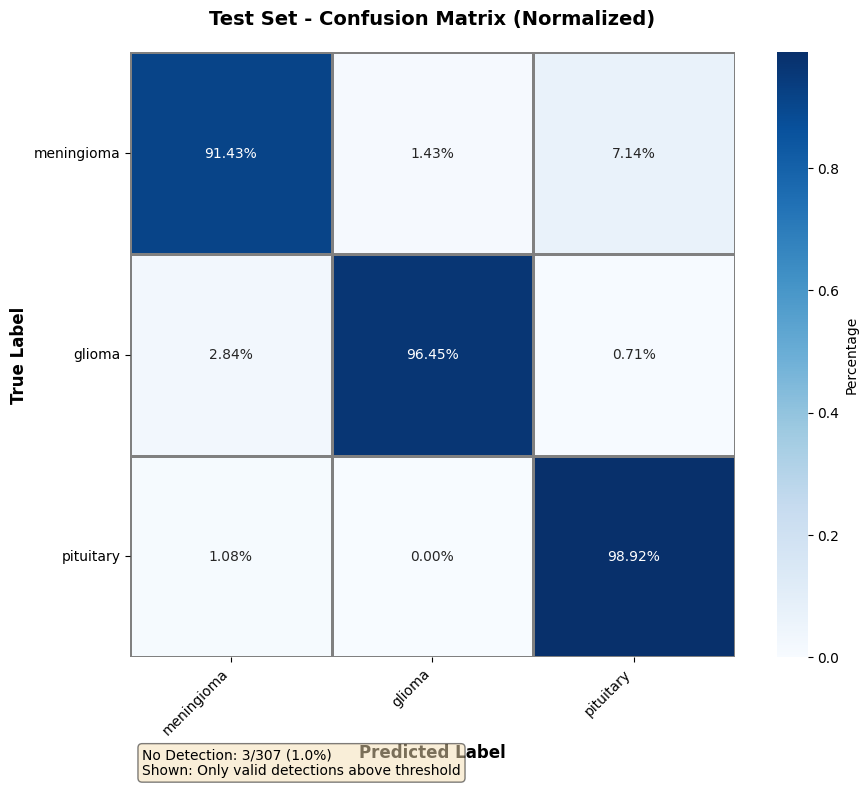


CLASSIFICATION REPORT (samo validne detekcije)
              precision    recall  f1-score   support

  meningioma       0.93      0.91      0.92        70
      glioma       0.99      0.96      0.98       141
   pituitary       0.94      0.99      0.96        93

    accuracy                           0.96       304
   macro avg       0.95      0.96      0.95       304
weighted avg       0.96      0.96      0.96       304


DETECTION STATISTICS
Ukupno uzoraka: 307
Validne detekcije (above threshold): 304 (99.0%)
No detection (below threshold): 3 (1.0%)

PER-CLASS ANALYSIS

MENINGIOMA (Class 1):
  Ground truth samples: 70
  Predicted as this class: 69
  Correctly classified: 64
  Class accuracy: 91.43%

GLIOMA (Class 2):
  Ground truth samples: 141
  Predicted as this class: 137
  Correctly classified: 136
  Class accuracy: 96.45%

PITUITARY (Class 3):
  Ground truth samples: 93
  Predicted as this class: 98
  Correctly classified: 92
  Class accuracy: 98.92%



VALIDATION vs TEST COM

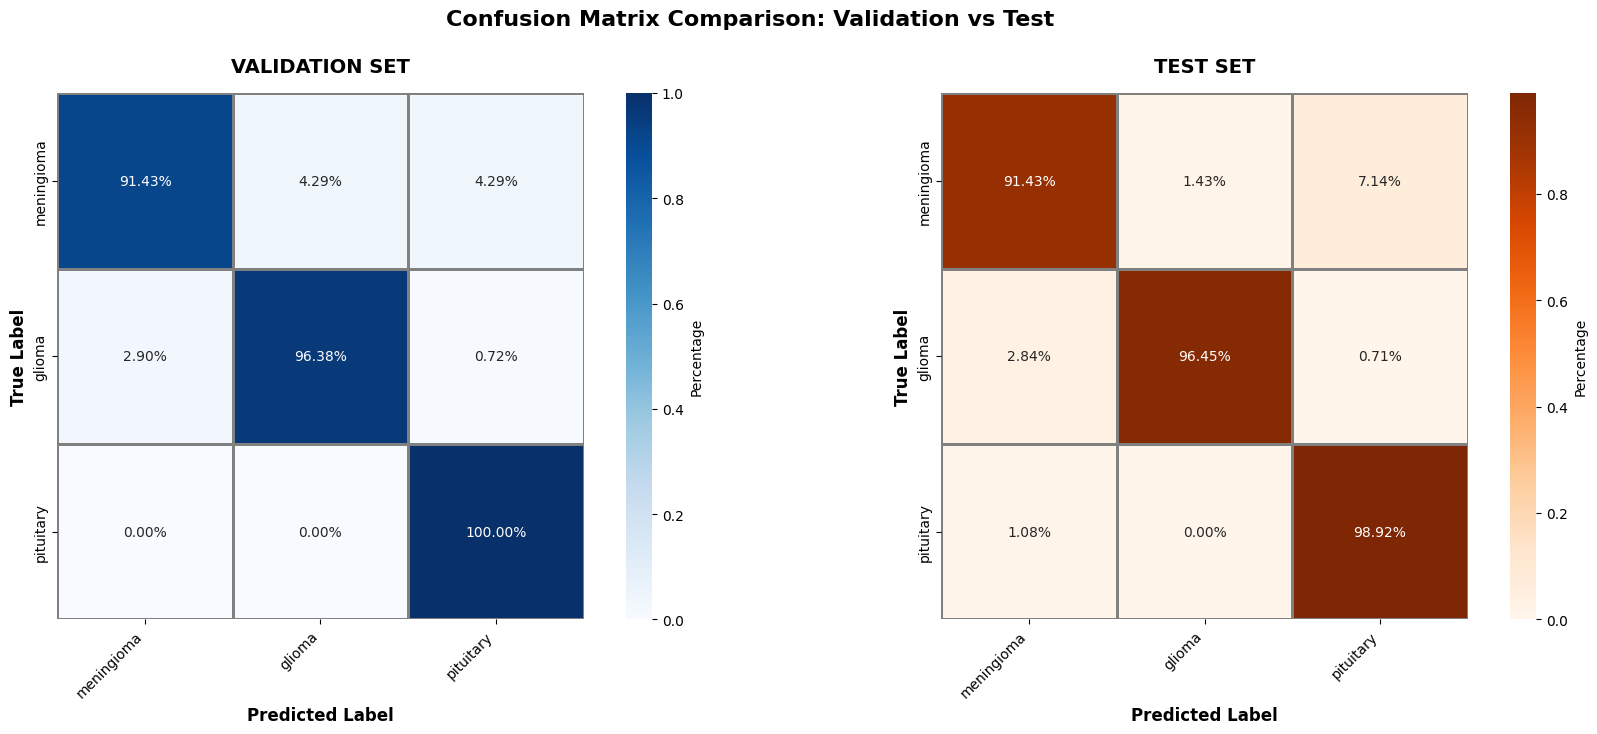

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch

def compute_confusion_matrix(model, dataloader, device, class_names):
    model.eval()
    y_true = []
    y_pred = []
    no_detection_count = 0

    print("Računanje predictions za confusion matrix...")

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Processing"):
            images, targets = move_to_device(images, targets, device)
            predictions = model(images)

            for pred, target in zip(predictions, targets):
                if len(target['labels']) > 0:
                    true_label = target['labels'][0].item()


                    if len(pred['boxes']) > 0 and len(pred['scores']) > 0:

                        best_idx = pred['scores'].argmax()
                        pred_label = pred['labels'][best_idx].item()
                        pred_score = pred['scores'][best_idx].item()


                        if pred_score > DETECTION_THRESHOLD:
                            y_true.append(true_label)
                            y_pred.append(pred_label)
                        else:

                            no_detection_count += 1
                    else:

                        no_detection_count += 1
    labels = [1, 2, 3]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    return y_true, y_pred, cm, no_detection_count

def plot_confusion_matrix(cm, class_names, no_detection_count=0, total_samples=0, title='Confusion Matrix', normalize=False):
    display_names = [class_names[i] for i in sorted(class_names.keys())]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2%'
        title += ' (Normalized)'
    else:
        fmt = 'd'

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=display_names,
                yticklabels=display_names,
                cbar_kws={'label': 'Count' if not normalize else 'Percentage'},
                square=True, linewidths=1, linecolor='gray')

    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)


    if no_detection_count > 0 and total_samples > 0:
        detection_rate = (total_samples - no_detection_count) / total_samples * 100
        info_text = f"No Detection: {no_detection_count}/{total_samples} ({100-detection_rate:.1f}%)\nShown: Only valid detections above threshold"
        plt.text(0.02, -0.15, info_text, transform=plt.gca().transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()
def print_classification_metrics(y_true, y_pred, class_names, no_detection_count, total_samples):
    print("\n" + "="*60)
    print("CLASSIFICATION REPORT (samo validne detekcije)")
    print("="*60)

    if len(y_true) > 0:
        labels = sorted(class_names.keys())
        target_names = [class_names[i] for i in labels]

        report = classification_report(
            y_true,
            y_pred,
            labels=labels,
            target_names=target_names,
            zero_division=0
        )
        print(report)
    else:
        print("Nema validnih detekcija!")


    print("\n" + "="*60)
    print("DETECTION STATISTICS")
    print("="*60)
    print(f"Ukupno uzoraka: {total_samples}")
    print(f"Validne detekcije (above threshold): {len(y_true)} ({len(y_true)/total_samples*100:.1f}%)")
    print(f"No detection (below threshold): {no_detection_count} ({no_detection_count/total_samples*100:.1f}%)")
    print("="*60)
def analyze_per_class_performance(y_true, y_pred, class_names):
    print("\n" + "="*60)
    print("PER-CLASS ANALYSIS")
    print("="*60)

    for class_id, class_name in sorted(class_names.items()):

        true_count = y_true.count(class_id)
        pred_count = y_pred.count(class_id)
        correct = sum(1 for t, p in zip(y_true, y_pred) if t == class_id and p == class_id)
        accuracy = correct / true_count * 100 if true_count > 0 else 0

        print(f"\n{class_name.upper()} (Class {class_id}):")
        print(f"  Ground truth samples: {true_count}")
        print(f"  Predicted as this class: {pred_count}")
        print(f"  Correctly classified: {correct}")
        print(f"  Class accuracy: {accuracy:.2f}%")

print("\n")
print("VALIDATION SET - CONFUSION MATRIX")
print("\n")

y_true_val, y_pred_val, cm_val, no_detect_val = compute_confusion_matrix(
    model, val_loader, DEVICE, CLASS_NAMES
)

total_val_samples = len(y_true_val) + no_detect_val


plot_confusion_matrix(cm_val, CLASS_NAMES, no_detect_val, total_val_samples,
                     title='Validation Set - Confusion Matrix')


plot_confusion_matrix(cm_val, CLASS_NAMES, no_detect_val, total_val_samples,
                     title='Validation Set - Confusion Matrix', normalize=True)

print_classification_metrics(y_true_val, y_pred_val, CLASS_NAMES, no_detect_val, total_val_samples)
analyze_per_class_performance(y_true_val, y_pred_val, CLASS_NAMES)

print("\n\n")
print("TEST SET - CONFUSION MATRIX")
print("\n")

y_true_test, y_pred_test, cm_test, no_detect_test = compute_confusion_matrix(
    model, test_loader, DEVICE, CLASS_NAMES
)

total_test_samples = len(y_true_test) + no_detect_test


plot_confusion_matrix(cm_test, CLASS_NAMES, no_detect_test, total_test_samples,
                     title='Test Set - Confusion Matrix')

plot_confusion_matrix(cm_test, CLASS_NAMES, no_detect_test, total_test_samples,
                     title='Test Set - Confusion Matrix', normalize=True)

print_classification_metrics(y_true_test, y_pred_test, CLASS_NAMES, no_detect_test, total_test_samples)
analyze_per_class_performance(y_true_test, y_pred_test, CLASS_NAMES)

print("\n\n")
print("VALIDATION vs TEST COMPARISON")
print("\n")

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

display_names = ['meningioma', 'glioma', 'pituitary']

cm_val_norm = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_val_norm, annot=True, fmt='.2%', cmap='Blues', ax=axes[0],
            xticklabels=display_names, yticklabels=display_names,
            square=True, linewidths=1, linecolor='gray', cbar_kws={'label': 'Percentage'})
axes[0].set_title('VALIDATION SET', fontsize=14, fontweight='bold', pad=15)
axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

cm_test_norm = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_test_norm, annot=True, fmt='.2%', cmap='Oranges', ax=axes[1],
            xticklabels=display_names, yticklabels=display_names,
            square=True, linewidths=1, linecolor='gray', cbar_kws={'label': 'Percentage'})
axes[1].set_title('TEST SET', fontsize=14, fontweight='bold', pad=15)
axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.suptitle('Confusion Matrix Comparison: Validation vs Test',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()
